In [34]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gizmo_analysis as gizmo
import utilities as ut
from sklearn.neighbors import KDTree
import yt
from luminosity_weight_pixels import *
import scipy


<!-- Load FIRE data: -->

In [2]:
simulation_directory = '/Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12b'
snap_idx = 600
part = gizmo.io.Read.read_snapshots('all', 'index', snap_idx, simulation_directory, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12b/snapshot_times.txt

* reading:  Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12b/snapshot_scalefactors.txt

* reading:  Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12b/snapshot_scale-factors.txt

cannot find file of snapshot times in /Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12b/

# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12b/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 58588459 particles
    star      (id = 4): 16869462 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'ga

<!-- find the centre of the position and the 90% stellar mass radius -->

In [3]:
centre = ut.particle.get_center_positions(part, species_name='star')
r_90 = ut.particle.get_galaxy_properties(part, species_name='star', center_position=centre, edge_kind='mass.percent')['radius']


# in utilities.particle.get_center_positions():
* assigning position for 1 center/host, via iterative zoom-in on star particle mass
  host1 position = (39256.76, 41610.01, 39190.29) [kpc comoving]

# in utilities.particle.get_galaxy_properties():
* M_star,sim = 1.02e11 Msun, log = 11.01
* M_star(< 20 kpc) = 9.42e10 Msun, log = 10.97
* R_star,90 = 10.9 kpc
* M_star,90 = 8.48e10 Msun, log = 10.93


<!-- Open the luminosity lookup table -->

In [4]:

tab_path     = f'/Users/tree/Documents/Uni/Masters_Degree/research_porject/HIILines/tables/SSP_Spectra_Conroy-et-al_v2.5_imfSalpeter.hdf5'

lookup_table, Z_lookup, t_lookup, nu, spectra = open_lookup_table(tab_path)

# get the freq. integrated L
L_lookup = get_total_L_lookup(spectra, nu)


<!-- Unpack the age, metallicity, coords of each star particle -->

In [5]:
f = 2 # points which fall within r <= f*r_90 are included

star_mask = part['star'].prop('host.distance.total') < f*r_90

t = part['star'].prop('age')[star_mask] # age in Gyr

Z = part['star'].prop('metallicity.metals')[star_mask] # Metallicity (log10(Z_sun))


star_coords = part['star'].prop('host.distance.principal')[star_mask] # 3D coords of each star

<!-- Unpack gas coords -->

In [ ]:
gas_mask = part['gas'].prop('host.distance.total') < f*r_90 # indices which fall in f of r_90

# 3D coords of each gas cell
gas_coords = part['gas'].prop('host.distance.principal')[gas_mask]



<!-- Match each star to a luminosity value from age (Gyr) and metallicity (log10(Z_sun)) -->

In [7]:
L = match_star_luminosities(Z, t, Z_lookup, t_lookup, L_lookup)

<!-- Find the nearest 1000 stars to each gas cell -->

In [8]:
distance, index = find_nearest_stars(gas_coords, star_coords, N_star=100)

<!-- Get the total of the contributions from closest 1000 stars for each gas cell -->

In [78]:
def project_illuminance(coords, gas_illuminance, N_px=100):
    illuminances, xs, ys = np.histogram2d(coords[:,0], coords[:,1], weights=gas_illuminance, bins=N_px)
    return illuminances.T, xs, ys



def project_density(coords, masses, N_px=100):
    density, xs, ys = np.histogram2d(coords[:,0], coords[:,1], weights=masses, bins=N_px)
    density /= (np.diff(xs)[0]*np.diff(ys)[0])
    return density.T, xs, ys


In [9]:
gas_illuminance = illuminate_gas(L, distance, index)

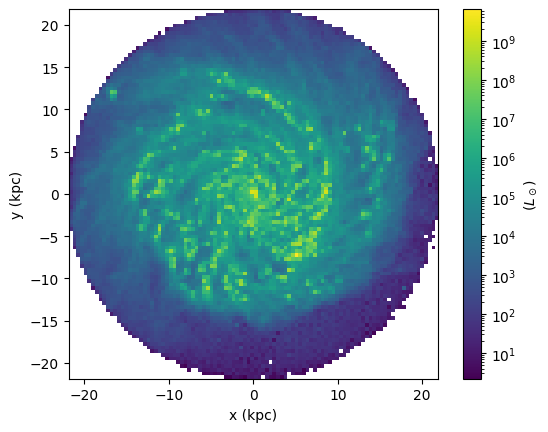

In [40]:
cutoff = 1000 # include pixels which are more illuminated than the sun

illuminances, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=gas_illuminance, bins=100)
# illuminances[illuminances<cutoff] = np.nan
plt.imshow(illuminances.T, norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(label=r'($L_\odot$)')


# density, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=part['gas'].prop('mass')[gas_mask], bins=100)

# plt.imshow(illuminances.T/(np.diff(xs)[0]*np.diff(ys)[0]), norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])

# plt.xlabel('x (kpc)')
# plt.ylabel('y (kpc)')
# plt.colorbar(label=r'($L_\odot$)')

<!-- Gas masses and metal mass: -->

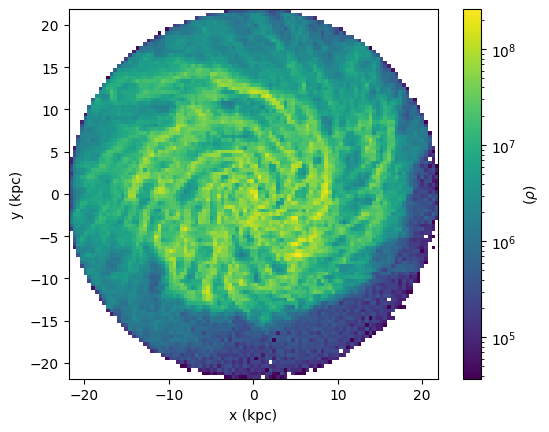

In [41]:
density, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=part['gas'].prop('mass')[gas_mask], bins=100)
density /= (np.diff(xs)[0]*np.diff(ys)[0])
plt.imshow(density.T, norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(label=r'($\rho$)')

Text(0, 0.5, 'illumination ($L_\\odot$)')

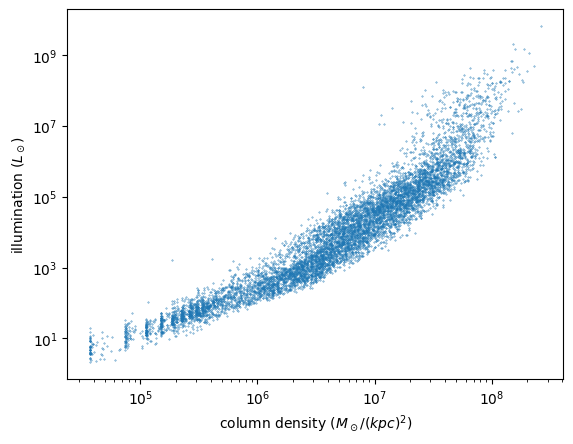

In [79]:
plt.scatter(density.flatten(), illuminances.flatten(), s=0.1)
plt.loglog()
plt.xlabel(r'column density ($M_\odot/(kpc)^2$)')
plt.ylabel(r'illumination ($L_\odot$)')

In [80]:
simulation_directory = '/Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12i'
snap_idx = 600
part = gizmo.io.Read.read_snapshots('all', 'index', snap_idx, simulation_directory, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12i/snapshot_times.txt

* reading:  Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12i/snapshot_scalefactors.txt

* reading:  Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12i/snapshot_scale-factors.txt

cannot find file of snapshot times in /Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12i/

# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/tree/Documents/Uni/Masters_Degree/research_porject/simulations/m12/m12i/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'ga

In [81]:
centre = ut.particle.get_center_positions(part, species_name='star')
r_90 = ut.particle.get_galaxy_properties(part, species_name='star', center_position=centre, edge_kind='mass.percent')['radius']


# in utilities.particle.get_center_positions():
* assigning position for 1 center/host, via iterative zoom-in on star particle mass
  host1 position = (41792.15, 44131.23, 46267.68) [kpc comoving]

# in utilities.particle.get_galaxy_properties():
* M_star,sim = 8.25e10 Msun, log = 10.92
* M_star(< 20 kpc) = 7.00e10 Msun, log = 10.85
* R_star,90 = 10.0 kpc
* M_star,90 = 6.30e10 Msun, log = 10.80


In [82]:
f = 2 # points which fall within r <= f*r_90 are included

star_mask = part['star'].prop('host.distance.total') < f*r_90

t = part['star'].prop('age')[star_mask] # age in Gyr

Z = part['star'].prop('metallicity.metals')[star_mask] # Metallicity (log10(Z_sun))


star_coords = part['star'].prop('host.distance.principal')[star_mask] # 3D coords of each star

In [83]:
gas_mask = part['gas'].prop('host.distance.total') < f*r_90 # indices which fall in f of r_90

# 3D coords of each gas cell
gas_coords = part['gas'].prop('host.distance.principal')[gas_mask]

L = match_star_luminosities(Z, t, Z_lookup, t_lookup, L_lookup)

In [84]:
distance, index = find_nearest_stars(gas_coords, star_coords, N_star=100)
gas_illuminance = illuminate_gas(L, distance, index)


In [85]:
illuminances, xs, ys = project_illuminance(gas_coords, gas_illuminance)

density, xs, ys = project_density(gas_coords, part['gas'].prop('mass')[gas_mask])

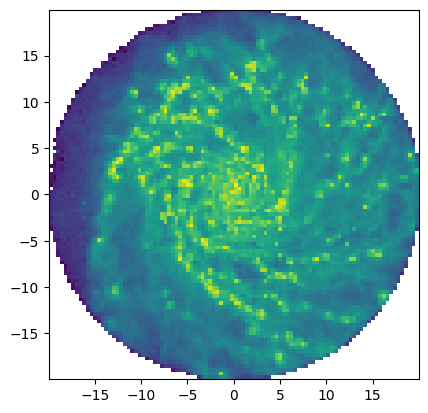

In [88]:
plt.imshow(illuminances, norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])

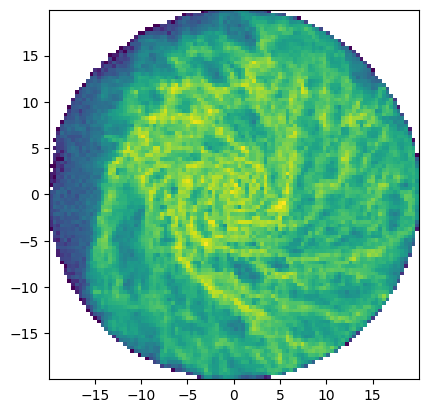

In [89]:
plt.imshow(density, norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])

Text(0, 0.5, 'illumination ($L_\\odot$)')

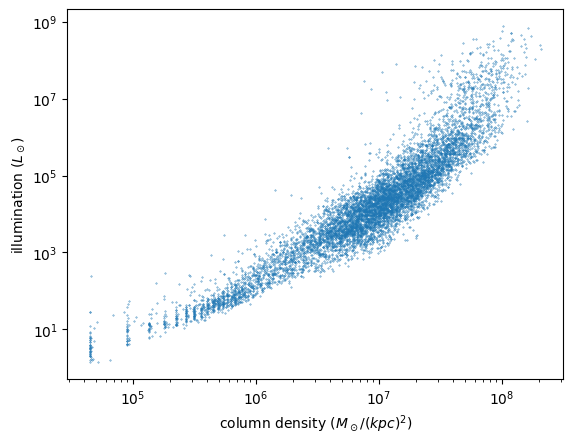

In [90]:
plt.scatter(density.flatten(), illuminances.flatten(), s=0.1)
plt.loglog()
plt.xlabel(r'column density ($M_\odot/(kpc)^2$)')
plt.ylabel(r'illumination ($L_\odot$)')

In [57]:
ill = illuminances.flatten()

np.log10(ill[(ill.nonzero()[0])]).min()
np.log10(ill[(ill.nonzero()[0])]).max()

9.816546044674375

In [71]:
np.log10(density.flatten()[ill.nonzero()[0]]).max()

8.418238199329357

Text(0, 0.5, 'illumination ($L_\\odot$)')

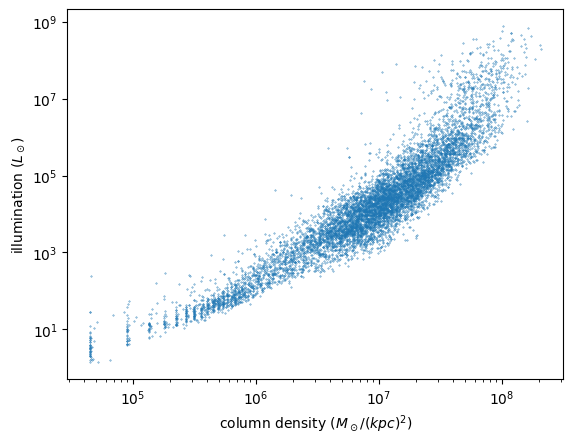

In [ ]:
def beta_finder(density, illuminances):
    
    density = density.flatten()
    illuminances = illuminances.flatten()
    log_sigma = np.log10(density[illuminances.nonzero()[0]])
    log_illuminance = np.log10(illuminances[illuminances.nonzero()[0]])

    stat = scipy.stats.linregress(log_sigma, log_illuminance)
    beta = stat.slope
    b = stat.intercept
    return beta, b

def get_line(beta, b, x1, x2):
    pass



plt.scatter(density.flatten(), illuminances.flatten(), s=0.1)
plt.loglog()
plt.xlabel(r'column density ($M_\odot/(kpc)^2$)')
plt.ylabel(r'illumination ($L_\odot$)')



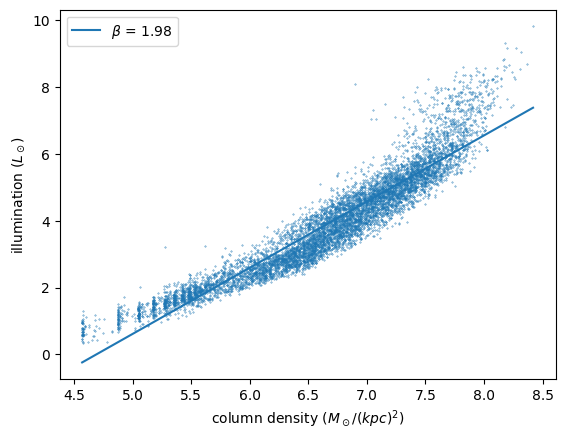

In [76]:
x1 = np.log10(density.flatten()[ill.nonzero()[0]]).min()
x2 = np.log10(density.flatten()[ill.nonzero()[0]]).max()
plt.scatter(np.log10(density.flatten()[ill.nonzero()[0]]), np.log10(ill[(ill.nonzero()[0])]), s=0.1)
# plt.loglog()
plt.plot(np.linspace(x1,x2), stat.slope*np.linspace(x1,x2) + stat.intercept, label=r'$\beta$ = ' + f'{stat.slope.round(2)}')
plt.xlabel(r'column density ($M_\odot/(kpc)^2$)')
plt.ylabel(r'illumination ($L_\odot$)')

plt.legend()

In [77]:
# np.log10(density.flatten())

stat = scipy.stats.linregress(np.log10(density.flatten()[ill.nonzero()[0]]), np.log10(ill[(ill.nonzero()[0])]))


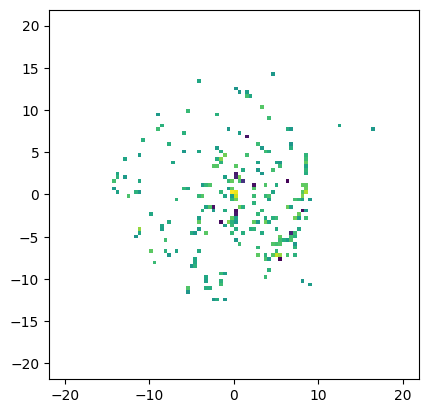

In [29]:
sfr_density, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=part['gas'].prop('sfr')[gas_mask], bins=100)
sfr_density /= (np.diff(xs)[0]*np.diff(ys)[0])
plt.imshow(density.T, norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])

Text(0, 0.5, 'illumination ($L_\\odot$)')

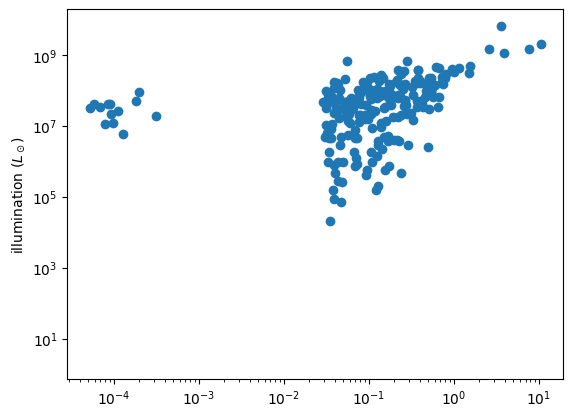

In [32]:
plt.scatter(sfr_density.flatten(), illuminances.flatten())
plt.loglog()
# plt.xlabel(r'column density ($M_\odot/(kpc)^2$)')
plt.ylabel(r'illumination ($L_\odot$)')

In [26]:
massfrac_metals = part['gas'].prop('massfraction.metals')[gas_mask]
mass = part['gas'].prop('mass')[gas_mask]


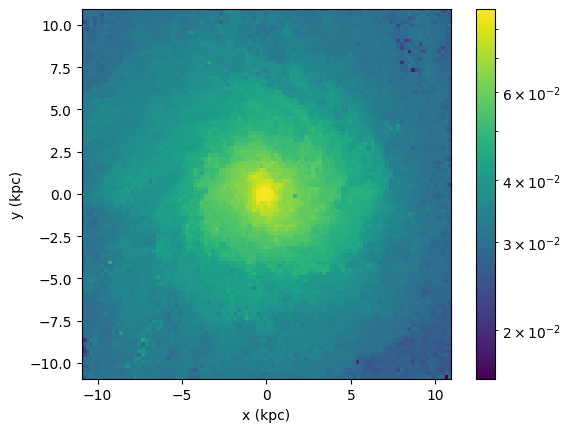

In [ ]:
cutoff = 1
f = 1
im_lims = np.array([-f*r_90, f*r_90,-f*r_90, f*r_90])

luminosity_weighted_massfrac_Z, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=(massfrac_metals * gas_illuminance), bins=100, range = im_lims.reshape(2,2))
illuminances, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=gas_illuminance, bins=100, range = im_lims.reshape(2,2))
luminosity_weighted_massfrac_Z[illuminances<cutoff] = np.nan
plt.imshow(luminosity_weighted_massfrac_Z.T/illuminances.T,norm=colors.LogNorm(), extent=im_lims)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar()

Z = luminosity_weighted_massfrac_Z.T/illuminances.T



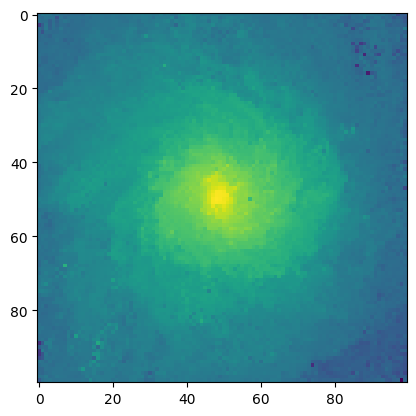

In [68]:
plt.imshow(np.log10(Z))

$$\frac{\sum_{i} (\rho_{Z}(x,y,z))_i L_i (\Delta z)_i}{\sum_{i} (\rho_{g}(x,y,z))_i L_i (\Delta z)_i}$$

In [ ]:
luminosity_weight = part['gas']['density'][gas_mask] * massfrac_metals * part['gas'].prop('size')[gas_mask] * gas_illuminance

In [ ]:
normalisation = part['gas']['density'][gas_mask] * part['gas'].prop('size')[gas_mask]

In [ ]:
luminosity_weighted_rho_Z, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=luminosity_weight, bins=100)
luminosity_weighted_rho, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=normalisation, bins=100)

/var/folders/w5/jz3pjyh15m97mgd7gv911fpr0000gn/T/ipykernel_27235/1844708089.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow((luminosity_weighted_rho_Z/luminosity_weighted_rho).T,norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])


Text(0, 0.5, 'y (kpc)')

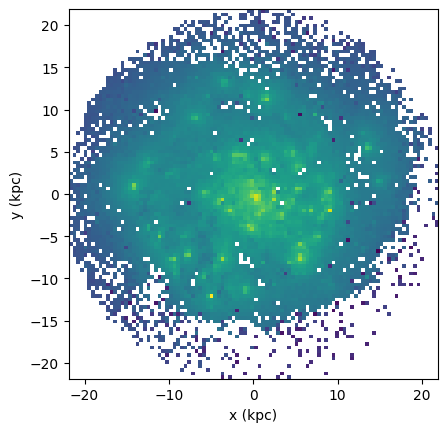

In [ ]:
plt.imshow((luminosity_weighted_rho_Z/luminosity_weighted_rho).T,norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')

<!-- $$\frac{\sum_{i} (\rho_{Z}(x,y,z))_i L_i (\Delta z)_i}{\sum_{i} (\rho_{g}(x,y,z))_i L_i (\Delta z)_i}$$ -->

$$\frac{\sum_{i} \frac{(m_{Z})_i}{m_i} L_i}{\sum_{i} L_i}$$

<!--  -->

In [27]:
luminosity_weighted_massfrac_Z, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=(massfrac_metals * gas_illuminance), bins=100)

In [28]:
illuminances, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=gas_illuminance, bins=100)

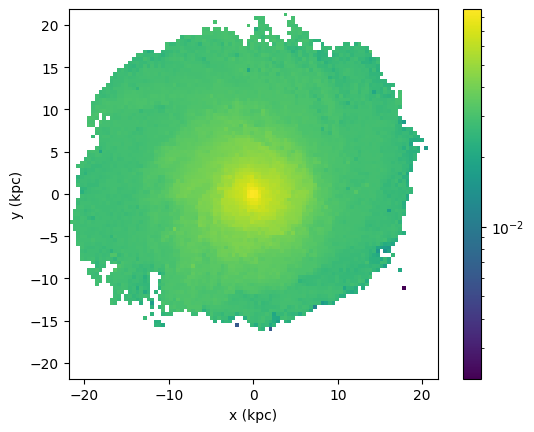

In [40]:
cutoff = 500
luminosity_weighted_massfrac_Z, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=(massfrac_metals * gas_illuminance), bins=100)
illuminances, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=gas_illuminance, bins=100)
luminosity_weighted_massfrac_Z[illuminances<cutoff] = np.nan
plt.imshow(luminosity_weighted_massfrac_Z.T/illuminances.T,norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar()

Z = luminosity_weighted_massfrac_Z.T/illuminances.T

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
density_weighted_Z, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=(part['gas']['density'][gas_mask] * massfrac_metals * part['gas'].prop('size')[gas_mask]), bins=100)

gas_density, xs, ys = np.histogram2d(gas_coords[:,0], gas_coords[:,1], weights=(part['gas']['density'][gas_mask] * part['gas'].prop('size')[gas_mask]), bins=100)

/var/folders/w5/jz3pjyh15m97mgd7gv911fpr0000gn/T/ipykernel_27235/3891378494.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(density_weighted_Z.T/gas_density.T,norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])


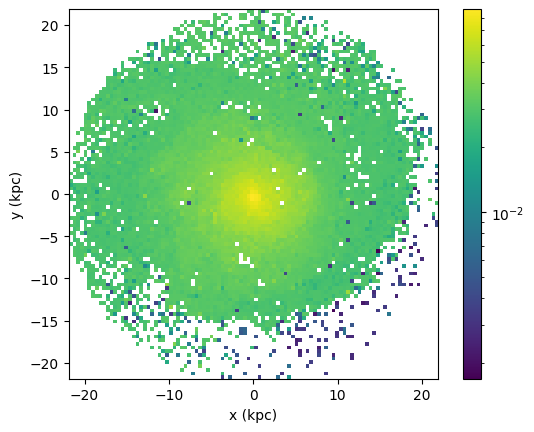

In [ ]:
plt.imshow(density_weighted_Z.T/gas_density.T,norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar()

In [4]:
ds = yt.load(f'{simulation_directory}/output/snapdir_{snap_idx}')
d = ds.all_data()

yt : [INFO     ] 2025-03-13 17:54:52,477 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2025-03-13 17:54:52,484 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2025-03-13 17:54:52,484 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2025-03-13 17:54:52,516 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2025-03-13 17:54:52,517 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-03-13 17:54:52,517 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-13 17:54:52,517 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2025-03-13 17:54:52,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-03-13 17:54:52,518 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2025-03-13 17:54:52,518 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2025-03-13 17:54:52,518 P

In [ ]:
proj_Z = ds.proj(field=("gas", "metallicity"), axis="z", center='m', method='integrate', weight_field=('gas', 'density'))
# proj.apply_units(('gas', 'density'), 'M_sun/kpc**2')
# save fixed resolution buffer
frb = proj_Z.to_frb(width=(30, "kpc"), resolution=[100,100])
rho_field_Z = frb[("gas", "metallicity")].to_ndarray()

yt : [INFO     ] 2025-03-13 12:34:07,744 max value is 2.65412e-20 at 27558.1969673385938222 29210.2273810140104615 27511.5919203679477505
yt : [INFO     ] 2025-03-13 12:34:07,745 Making a fixed resolution buffer of (('gas', 'metallicity')) 100 by 100
yt : [INFO     ] 2025-03-13 12:35:16,203 Making a fixed resolution buffer of (('gas', 'density')) 100 by 100


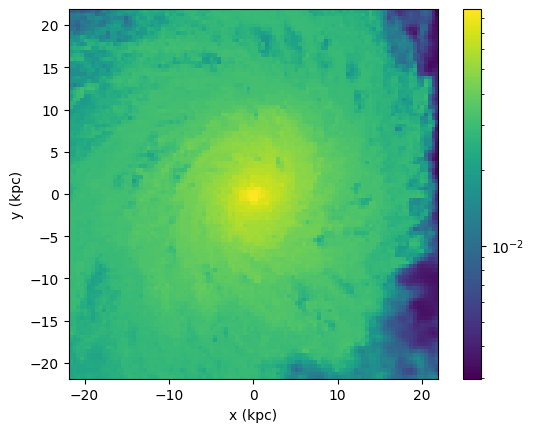

In [ ]:
plt.imshow(rho_field_Z, norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar()

In [ ]:
star_L_proj, xs, ys = np.histogram2d(star_coords[:,0], star_coords[:,1], weights=L*part['star'].prop('mass')[star_mask], bins=100)
star_M, xs, ys = np.histogram2d(star_coords[:,0], star_coords[:,1], weights=part['star'].prop('mass')[star_mask], bins=100)

/var/folders/w5/jz3pjyh15m97mgd7gv911fpr0000gn/T/ipykernel_27235/3650010774.py:1: RuntimeWarning: invalid value encountered in divide
  L_weighed_rho_star = star_L_proj.T/star_M.T


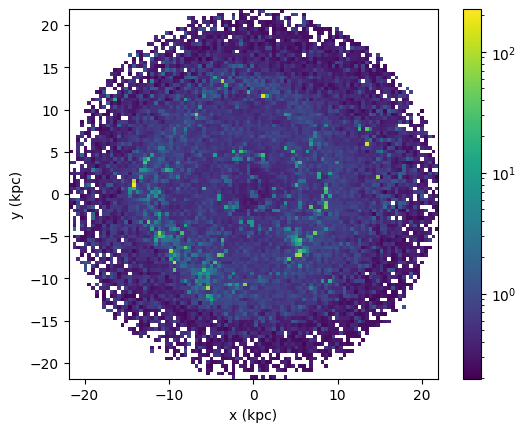

In [ ]:
L_weighed_rho_star = star_L_proj.T/star_M.T
# L_weighed_rho_star[L_weighed_rho_star<1] = np.nan
plt.imshow(L_weighed_rho_star, norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar()

In [ ]:
star_M, xs, ys = np.histogram2d(star_coords[:,0], star_coords[:,1], weights=part['star'].prop('mass')[star_mask], bins=300)

star_M/= np.diff(xs)[0] * np.diff(ys)[0]

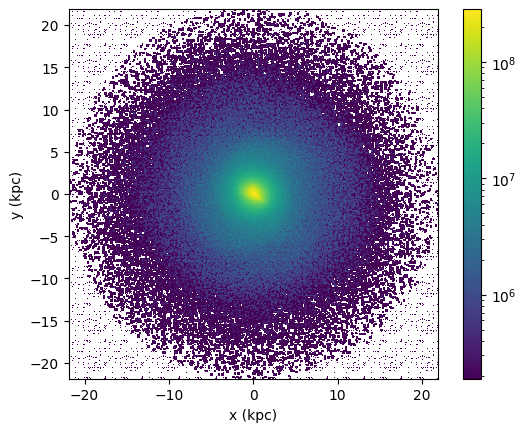

In [ ]:
# plt.imshow(star_M, norm=colors.LogNorm(), extent=[-f*r_90, f*r_90,-f*r_90, f*r_90])
# plt.xlabel('x (kpc)')
# plt.ylabel('y (kpc)')
# plt.colorbar()

$$\frac{\sum_{i} (Z)_i \rho_{g}(x,y,z) L_i (\Delta z)_i}{\sum_{i} (\rho_{g}(x,y,z))_i L_i (\Delta z)_i}$$

In [25]:
ds.derived_field_list

[('PartType0', 'C_metallicity'),
 ('PartType0', 'C_nuclei_density'),
 ('PartType0', 'C_nuclei_mass_density'),
 ('PartType0', 'Ca_metallicity'),
 ('PartType0', 'Ca_nuclei_density'),
 ('PartType0', 'Ca_nuclei_mass_density'),
 ('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'El_number_density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'Fe_metallicity'),
 ('PartType0', 'Fe_nuclei_density'),
 ('PartType0', 'Fe_nuclei_mass_density'),
 ('PartType0', 'H_nuclei_density'),
 ('PartType0', 'H_p0_density'),
 ('PartType0', 'H_p0_fraction'),
 ('PartType0', 'H_p0_mass'),
 ('PartType0', 'H_p0_number_density'),
 ('PartType0', 'H_p1_density'),
 ('PartType0', 'H_p1_fraction'),
 ('PartType0', 'H_p1_mass'),
 ('PartType0', 'H_p1_number_density'),
 ('PartType0', 'He_metallicity'),
 ('PartType0', 'He_nuclei_density'),
 ('PartType0', 'He_nuclei_mass_density'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity_00'),
 ('PartType0', 'Metalli

In [ ]:
# ds = yt.load(f'{simulation_directory}/output/snapdir_{snap_idx}')
def Luminosity(field, data, Z_lookup, t_lookup, L_lookup, N_star):
    Z_star = np.log10(data['PartType4', 'Metallicity_00']/0.0134)
    age_star = data[('PartType4', 'age')].to('Gyr')
    L = match_star_luminosities(Z_star, age_star, Z_lookup, t_lookup, L_lookup)
    gas_coords = data[('gas', 'position')].to('kpc')
    star_coords = data[('PartType4', 'particle_position')].to('kpc')
    distance, index = find_nearest_stars(gas_coords, star_coords, N_star)
    gas_illuminance = illuminate_gas(L, distance, index)
    
    return gas_illuminance
    # return (3 / 2) * data["gas", "number_density"] * data["gas", "kT"]
ds.add_field(
    ("gas", "illuminance"),
    units="L_sun",
    function=lambda field, data: Luminosity(field, data, Z_lookup, t_lookup, L_lookup, 1000),
    sampling_type="cell",
)
# proj = ds.proj(field=("PartType4", "luminosity"), axis="z", center='m', method='integrate')
# frb = proj.to_frb(width=(30, "kpc"), resolution=[100,100])
# # field_lum = frb[("PartType4", "luminosity")].to_ndarray()

ValueError: k must be less than or equal to the number of training points

In [ ]:
d[('PartType4', 'particle_position')].to('kpc')


unyt_array([[37567.03215553, 39853.50836248, 34360.94171781],
       [37650.98982812, 40026.84745962, 34376.38335866],
       [37598.0128135 , 39897.3370008 , 34273.91862415],
       ...,
       [39241.47285779, 41638.66737288, 39200.40793537],
       [39241.47247245, 41638.68729199, 39200.47612485],
       [39241.53440978, 41638.95250016, 39200.1115491 ]], 'kpc')

In [ ]:
frb = proj_Z.to_frb(width=(30, "kpc"), resolution=[100,100])
rho_field_Z = frb[("gas", "metallicity")].to_ndarray()

unyt_array([10.7876547 , 10.78751424, 10.78755298, ..., 11.74414462,
        9.33715963,  8.21873476], 'Gyr')

In [5]:
sp = ds.sphere("max", (30, "kpc"))

yt : [INFO     ] 2025-03-13 17:55:15,673 max value is 2.65412e-20 at 27558.1969673385938222 29210.2273810140104615 27511.5919203679477505


In [6]:
Z_star = np.log10(sp['PartType4', 'Metallicity_00']/0.0134)
age_star = sp[('PartType4', 'age')].to('Gyr')
gas_coords = sp[('gas', 'position')].to('kpc')
star_coords = sp[('PartType4', 'particle_position')].to('kpc')

In [9]:
L = match_star_luminosities(Z_star, age_star, Z_lookup, t_lookup, L_lookup)

In [12]:
distance, index = find_nearest_stars(gas_coords, star_coords, 100)
gas_illuminance = illuminate_gas(L, distance, index)

array([225.23282678, 209.87445032, 211.92496455, ...,   1.86269309,
         1.88498881,   1.83498714])

In [15]:
def Luminosity(field, data, Z_lookup, t_lookup, L_lookup, N_star):
    Z_star = np.log10(data['PartType4', 'Metallicity_00']/0.0134)
    age_star = data[('PartType4', 'age')].to('Gyr')
    L = match_star_luminosities(Z_star, age_star, Z_lookup, t_lookup, L_lookup)
    gas_coords = data[('gas', 'position')].to('kpc')
    star_coords = data[('PartType4', 'particle_position')].to('kpc')
    distance, index = find_nearest_stars(gas_coords, star_coords, N_star)
    gas_illuminance = illuminate_gas(L, distance, index)
    
    return gas_illuminance
ds.add_field(
    ("gas", "illuminance"),
    units="L_sun",
    function=lambda field, data: Luminosity(field, data, Z_lookup, t_lookup, L_lookup, 10),
    sampling_type="cell",
)

yt : [WARNING  ] 2025-03-13 17:57:37,122 Field ('gas', 'illuminance') already exists. To override use `force_override=True`.


ValueError: k must be less than or equal to the number of training points